# Predictive Maintenance - Machine Failure Prediction

## Step 1 — Data Loading
Loading the AI4I 2020 Predictive Maintenance Dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.feature_selection import RFE 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("ai4i2020.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

## Step 2 — Data Inspection
Checking data types, missing values, and duplicate records.

In [3]:
print("Number of missing values:\n", df.isnull().sum())
print("Number of duplicated rows:", df.duplicated().sum())

Number of missing values:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64
Number of duplicated rows: 0


In [4]:
X  = df.drop(columns=['Machine failure','UDI', 'Product ID','TWF','HDF', 'PWF', 'OSF', 'RNF'])
y = pd.Series(df['Machine failure'], name='Machine failure')
print(X.head())
print(y.head())

  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  
0         42.8                0  
1         46.3                3  
2         49.4                5  
3         39.5                7  
4         40.0                9  
0    0
1    0
2    0
3    0
4    0
Name: Machine failure, dtype: int64


## Step 3 — Exploratory Data Analysis (EDA)
Computing basic statistics and analyzing distributions of key variables.

In [5]:
numirical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]','Torque [Nm]', 'Tool wear [min]']
X.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


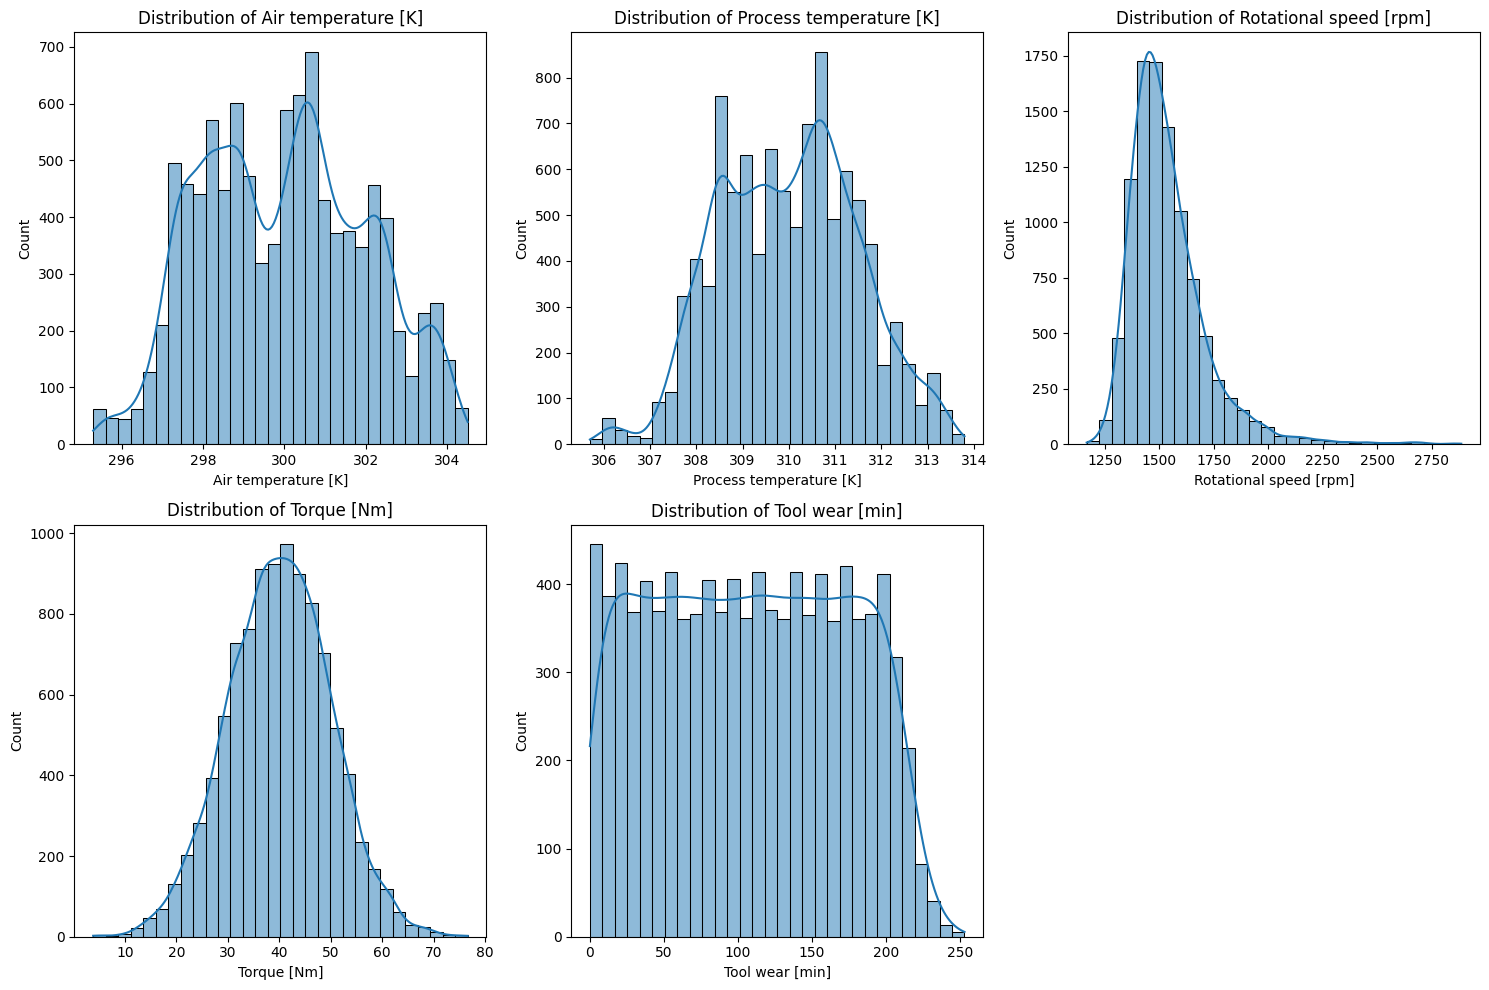

In [6]:
plt.figure(figsize=(15,10))
for i, feature in enumerate(numirical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()



Machine failure
0    9661
1     339
Name: count, dtype: int64


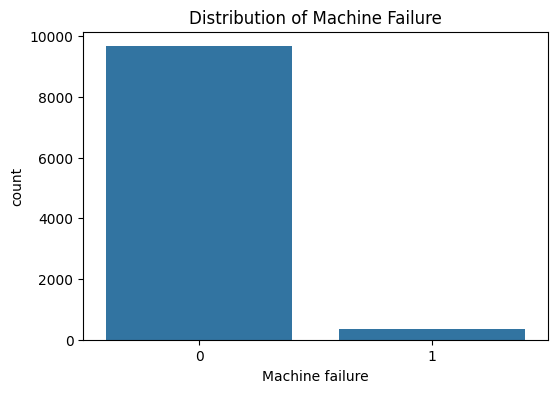

In [7]:
print(y.value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Distribution of Machine Failure')
plt.show()

### Target Variable Distribution
Examining the class distribution of machine failure (imbalanced dataset).

## Step 4 — Feature Engineering

### Engineered Features Definition & Rules

| Feature | Definition | Formula |
|---------|------------|---------|
| **Stress_Index** | Mechanical stress during operation | Torque × Rotational_Speed / 1000 |
| **Tool_Wear_Rate** | Tool degradation rate relative to operation | Tool_Wear / (Rotational_Speed / 1000) |
| **Temp_Difference** | Thermal stress and cooling efficiency | Process_Temp − Air_Temp |
| **Energy_Indicator** | Mechanical power applied (Watts) | Torque × (Rotational_Speed × 2π / 60) |
| **Degradation_Index** | Cumulative degradation normalized by workload | (Tool_Wear × Torque) / Temp_Difference |

In [6]:
X['Stress_Index'] = (X['Torque [Nm]'] * X['Rotational speed [rpm]']) / 1000
X['Tool_Wear_Rate'] = X['Tool wear [min]'] / (X['Rotational speed [rpm]'] / 1000)
X['Temp_Difference'] = X['Process temperature [K]'] - X['Air temperature [K]']
X['Energy_Indicator'] = X['Torque [Nm]'] * (X['Rotational speed [rpm]'] * 2 * np.pi / 60)
X['Degradation_Index'] = (X['Tool wear [min]'] * X['Torque [Nm]']) / X['Temp_Difference']

new_features = ['Stress_Index', 'Tool_Wear_Rate', 'Temp_Difference', 'Energy_Indicator', 'Degradation_Index']
X[new_features].describe()

,Stress_Index,Tool_Wear_Rate,Temp_Difference,Energy_Indicator,Degradation_Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,59.967147,70.965019,10.000630,6279.744953,436.073182
std,10.193094,42.618969,1.001094,1067.418295,291.166603
min,10.966800,0.000000,7.600000,1148.440610,0.000000
25%,53.105400,34.545227,9.300000,5561.184484,194.873377
50%,59.883900,69.993207,9.800000,6271.027344,404.504545
75%,66.873750,105.679124,11.000000,7003.002724,632.626901
max,99.980400,185.419968,12.100000,10469.923005,1923.012821


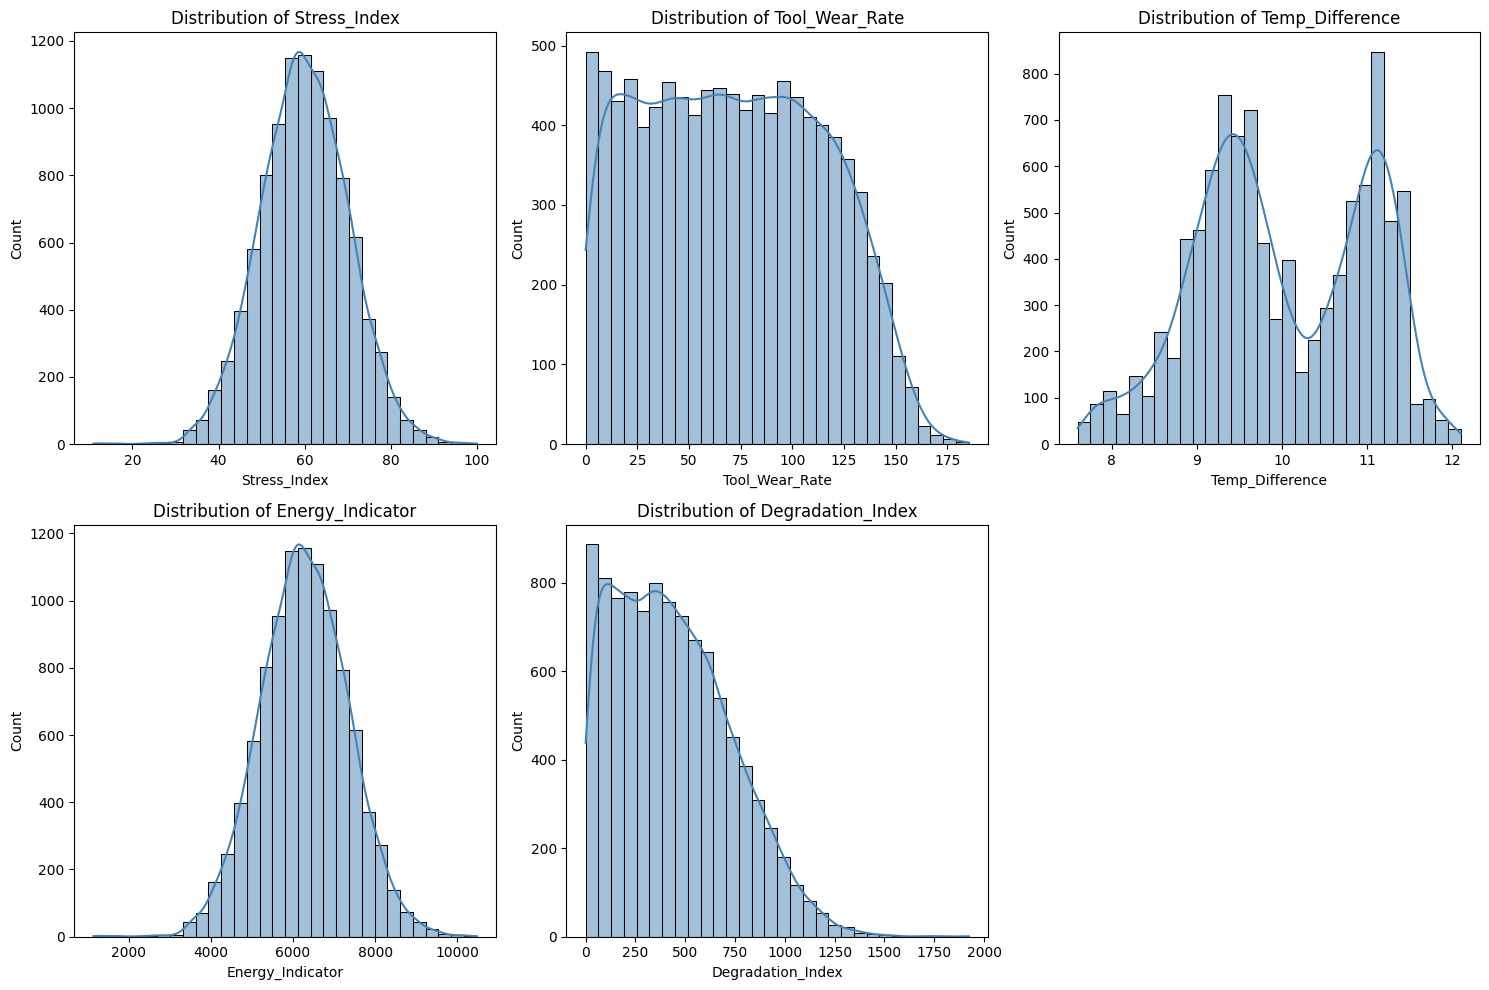

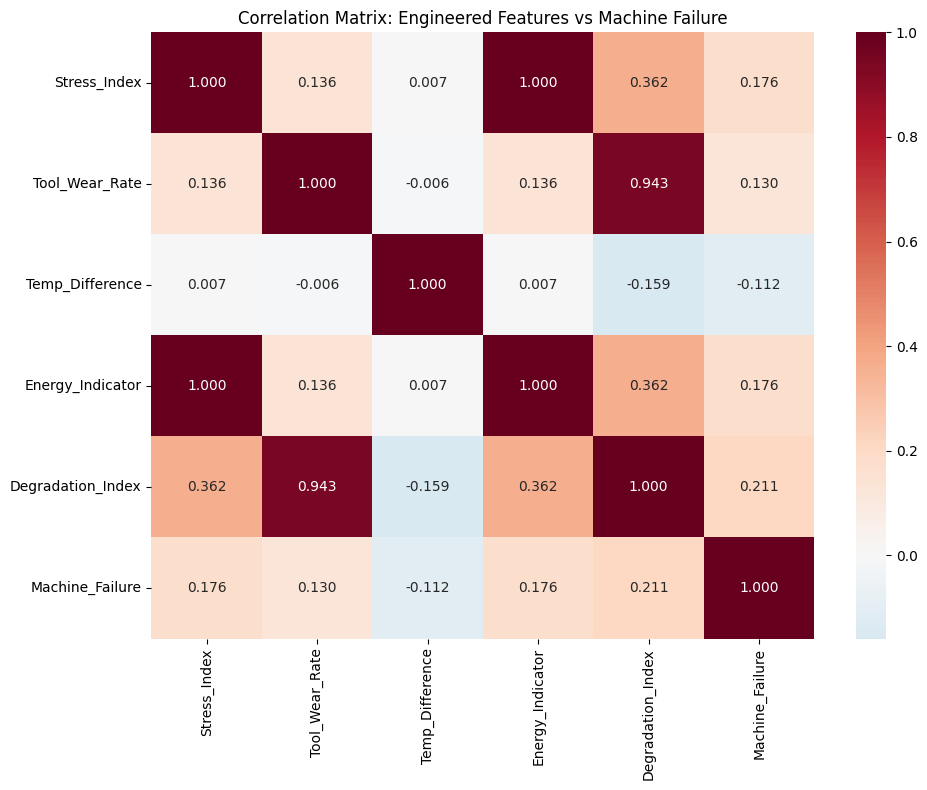

In [9]:
new_features = ['Stress_Index', 'Tool_Wear_Rate', 'Temp_Difference', 'Energy_Indicator', 'Degradation_Index']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(new_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X[feature], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
plt.tight_layout()
plt.show()

correlation_df = X[new_features].copy()
correlation_df['Machine_Failure'] = y.values
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap='RdBu_r', center=0, fmt='.3f')
plt.title('Correlation Matrix: Engineered Features vs Machine Failure')
plt.tight_layout()
plt.show()

## Step 5 — Data Preprocessing

### Why Scaling is Important
- **Distance-based algorithms** (KNN, SVM) are sensitive to feature magnitudes
- **Gradient-based optimization** converges faster with standardized features
- Features with larger ranges would dominate the model without scaling

### Data Split Strategy
- **80% Training / 20% Testing** split with `random_state=42` for reproducibility
- Stratified split preserves class distribution in imbalanced data

### Categorical Encoding
Converting 'Type' (L, M, H) to numerical using Label Encoding.

In [7]:
le = LabelEncoder()
X['Type'] = le.fit_transform(X['Type'])
X.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Stress_Index,Tool_Wear_Rate,Temp_Difference,Energy_Indicator,Degradation_Index
0,2,298.1,308.6,1551,42.8,0,66.3828,0.000000,10.5,6951.590560,0.000000
1,1,298.2,308.7,1408,46.3,3,65.1904,2.130682,10.5,6826.722724,13.228571
2,1,298.1,308.5,1498,49.4,5,74.0012,3.337784,10.4,7749.387543,23.750000
3,1,298.2,308.6,1433,39.5,7,56.6035,4.884857,10.4,5927.504659,26.586538
4,1,298.2,308.7,1408,40.0,9,56.3200,6.392045,10.5,5897.816608,34.285714


### Train-Test Split & Feature Scaling
Applying StandardScaler to numerical features (excluding encoded 'Type').

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
numerical_cols = X_train.columns.drop('Type')

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train_scaled.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Stress_Index,Tool_Wear_Rate,Temp_Difference,Energy_Indicator,Degradation_Index
4058,2,0.998914,0.604282,-0.460607,0.718305,-0.843997,0.852387,-0.791347,-1.100842,0.852387,-0.510806
1221,2,-1.505194,-1.153260,-0.775574,0.638456,0.382263,0.480363,0.554513,1.299658,0.480363,0.369841
6895,2,0.498092,1.077466,-1.007654,0.558607,0.460870,0.184041,0.709742,0.599512,0.184041,0.532927
9863,1,-0.553633,-0.139294,-0.709265,1.626586,-0.372359,1.898861,-0.263855,0.899575,1.898861,-0.002715
8711,1,-1.455112,-1.018064,1.070019,-1.128202,-0.906882,-1.001687,-0.984916,1.399679,-1.001687,-1.063735


## Step 6 — Feature Selection

### A. Filter Feature Selection
1. **Correlation Analysis**: Remove highly correlated features (threshold > 0.9)
2. **ANOVA F-test**: Rank features by statistical relevance to target

In [12]:
# Filter Feature Selection
def drop_redundant_features(X,threshold=0.9 , method='pearson'):
    corr_matrix = X.corr(method=method)
    redundant_pairs = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):    # loop only through lower triangle
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname1 = corr_matrix.columns[i]
                colname2 = corr_matrix.columns[j]
                redundant_pairs.add((colname1, colname2))
    print(f"Redundant feature pairs (threshold={threshold}): {redundant_pairs}")
    features_to_drop = set()
    for pair in redundant_pairs:
        features_to_drop.add(pair[0])
    X_reduced = X.drop(columns=features_to_drop)
    return X_reduced, features_to_drop

X_reduced, dropped_features = drop_redundant_features(X, threshold=0.9, method='pearson')
print(f"Dropped features using function: {dropped_features}")

    

Redundant feature pairs (threshold=0.9): {('Energy_Indicator', 'Stress_Index'), ('Degradation_Index', 'Tool_Wear_Rate'), ('Tool_Wear_Rate', 'Tool wear [min]'), ('Energy_Indicator', 'Torque [Nm]'), ('Stress_Index', 'Torque [Nm]')}
Dropped features using function: {'Degradation_Index', 'Tool_Wear_Rate', 'Energy_Indicator', 'Stress_Index'}


Text(0.5, 1.0, 'Reduced Pearson Correlation Matrix')

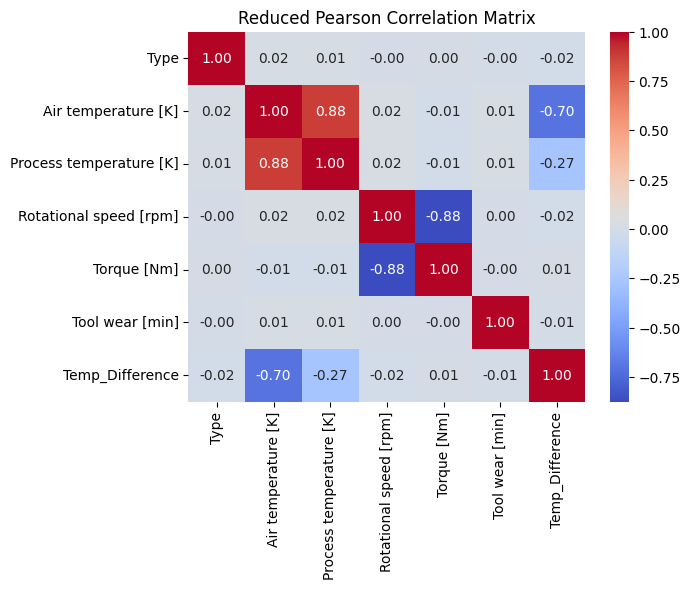

In [13]:
sns.heatmap(X_reduced.corr(method='pearson'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Reduced Pearson Correlation Matrix')

C:\Users\mosta\AppData\Local\Temp\ipykernel_26040\544244908.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F-Score', y='Feature', data=anova_df, palette='viridis')


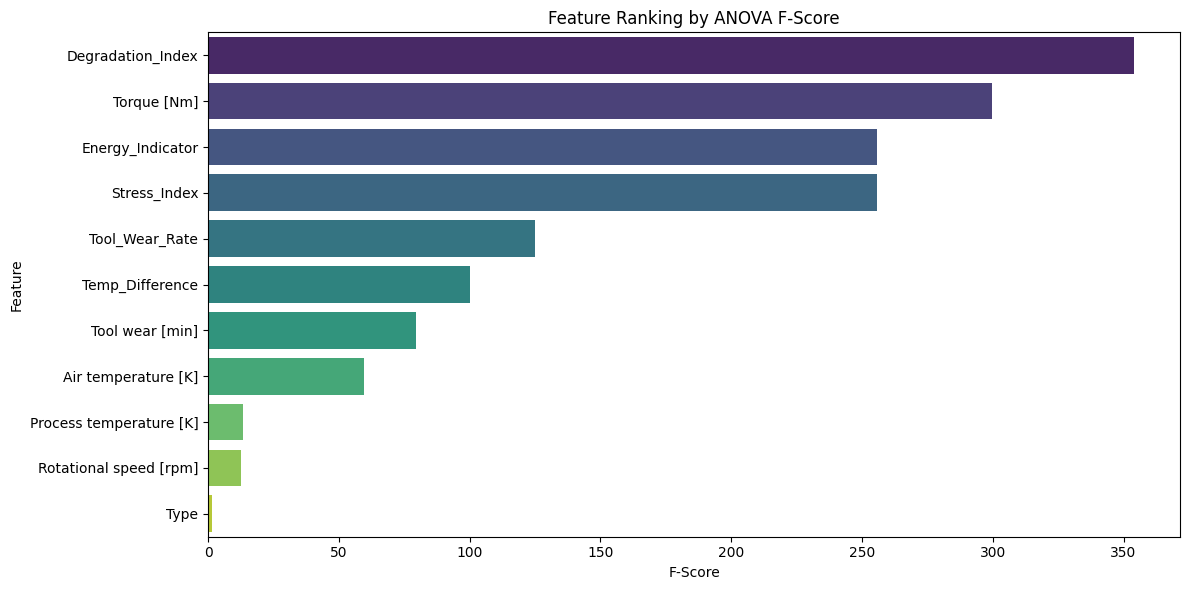

,Feature,F-Score
10,Degradation_Index,353.903958
4,Torque [Nm],299.652691
9,Energy_Indicator,255.657231
6,Stress_Index,255.657231
7,Tool_Wear_Rate,125.106147
8,Temp_Difference,100.344203
5,Tool wear [min],79.510174
1,Air temperature [K],59.595325
2,Process temperature [K],13.368058
3,Rotational speed [rpm],12.795748


In [14]:
f_scores,_ = f_classif(X_train_scaled, y_train)
anova_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'F-Score': f_scores
}).sort_values('F-Score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='F-Score', y='Feature', data=anova_df, palette='viridis')
plt.title('Feature Ranking by ANOVA F-Score')
plt.tight_layout()
plt.show()

anova_df

### B. Wrapper Feature Selection
Using Recursive Feature Elimination (RFE) with Random Forest as the estimator.

In [15]:
rf_model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf_model, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)

selected_features = X_train_scaled.columns[rfe.support_]
rfe_ranking = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Ranking': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values('Ranking')

rfe_ranking

,Feature,Ranking,Selected
1,Air temperature [K],1,True
2,Process temperature [K],1,True
3,Rotational speed [rpm],1,True
4,Torque [Nm],1,True
6,Stress_Index,1,True
5,Tool wear [min],1,True
7,Tool_Wear_Rate,1,True
8,Temp_Difference,1,True
10,Degradation_Index,1,True
9,Energy_Indicator,1,True


### Performance Comparison: All Features vs. Selected Features

In [16]:
rf_all = RandomForestClassifier(random_state=42)
rf_all.fit(X_train_scaled, y_train)
y_pred_all = rf_all.predict(X_test_scaled)
acc_all = metrics.accuracy_score(y_test, y_pred_all)
f1_all = metrics.f1_score(y_test, y_pred_all)

X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)
y_pred_selected = rf_selected.predict(X_test_selected)
acc_selected = metrics.accuracy_score(y_test, y_pred_selected)
f1_selected = metrics.f1_score(y_test, y_pred_selected)

comparison_df = pd.DataFrame({
    'Feature Set': ['All Features', 'RFE Selected (10)'],
    'Num Features': [X_train_scaled.shape[1], len(selected_features)],
    'Accuracy': [acc_all, acc_selected],
    'F1-Score': [f1_all, f1_selected]
})
comparison_df

,Feature Set,Num Features,Accuracy,F1-Score
0,All Features,11,0.9915,0.866142
1,RFE Selected (10),10,0.9885,0.809917


## Step 6 — Model Training
Training four machine learning models with default hyperparameters.

In [16]:
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
print("SCM report:" )
print(metrics.classification_report(y_test, y_pred))

SCM report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.80      0.29      0.43        68

    accuracy                           0.97      2000
   macro avg       0.89      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



In [11]:
dt_model = DecisionTreeClassifier(random_state=42) 
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
print("Decision Tree Classification Report:")
print(metrics.classification_report(y_test, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.72      0.69      0.71        68

    accuracy                           0.98      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.98      0.98      0.98      2000



In [12]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Classification Report:")
print(metrics.classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.93      0.81      0.87        68

    accuracy                           0.99      2000
   macro avg       0.96      0.90      0.93      2000
weighted avg       0.99      0.99      0.99      2000



In [14]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled.values, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled.values)
print("XGBoost Classification Report:")
print(metrics.classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.86      0.74      0.79        68

    accuracy                           0.99      2000
   macro avg       0.93      0.87      0.89      2000
weighted avg       0.99      0.99      0.99      2000



## Step 7 — Model Evaluation
Comparing all models using Accuracy, Precision, Recall, and F1-Score.

In [17]:
def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Precision': metrics.precision_score(y_true, y_pred),
        'Recall': metrics.recall_score(y_true, y_pred),
        'F1-Score': metrics.f1_score(y_true, y_pred)
    }

y_pred_svm = svm_model.predict(X_test_scaled)

results_before = pd.DataFrame({
    'SVM': evaluate_model(y_test, y_pred_svm),
    'Decision Tree': evaluate_model(y_test, y_pred_dt),
    'Random Forest': evaluate_model(y_test, y_pred_rf),
    'XGBoost': evaluate_model(y_test, y_pred_xgb)
}).T

results_before

,Accuracy,Precision,Recall,F1-Score
SVM,0.9735,0.800000,0.294118,0.430108
Decision Tree,0.9805,0.723077,0.691176,0.706767
Random Forest,0.9915,0.932203,0.808824,0.866142
XGBoost,0.9870,0.862069,0.735294,0.793651


### Initial Model Performance Analysis

**Best Performing Model**: Random Forest and XGBoost typically perform best due to their ensemble nature.

**Most Important Metric**: **Recall** is the most important metric for predictive maintenance because:
- Missing a machine failure (False Negative) is costly — leads to unplanned downtime, equipment damage, and safety risks
- It's better to have false alarms than to miss actual failures
- F1-Score is also important as it balances precision and recall

## Step 8 — Hyperparameter Tuning

### Grid Search (SVM, Decision Tree, Random Forest)

**Hyperparameters tuned:**
- **SVM**: `C` (regularization), `kernel` (decision boundary type), `gamma` (kernel coefficient)
- **Decision Tree**: `max_depth` (tree complexity), `min_samples_split`, `criterion`
- **Random Forest**: `n_estimators` (number of trees), `max_depth`, `min_samples_split`

These parameters control model complexity and help prevent overfitting/underfitting.

In [18]:
svm_params = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(SVC(random_state=42), svm_params, cv=3, scoring='f1')
svm_grid.fit(X_train_scaled, y_train)
print("SVM Best Parameters:", svm_grid.best_params_)

svm_tuned = svm_grid.best_estimator_
y_pred_svm_tuned = svm_tuned.predict(X_test_scaled)

SVM Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [19]:
dt_params = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=3, scoring='f1')
dt_grid.fit(X_train_scaled, y_train)
print("Decision Tree Best Parameters:", dt_grid.best_params_)

dt_tuned = dt_grid.best_estimator_
y_pred_dt_tuned = dt_tuned.predict(X_test_scaled)

Decision Tree Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}


In [20]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1')
rf_grid.fit(X_train_scaled, y_train)
print("Random Forest Best Parameters:", rf_grid.best_params_)

rf_tuned = rf_grid.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test_scaled)

Random Forest Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


### Random Search (XGBoost)

**Hyperparameters tuned:**
- `n_estimators`: Number of boosting rounds
- `learning_rate`: Step size shrinkage to prevent overfitting
- `max_depth`: Maximum tree depth
- `subsample`: Fraction of samples used per tree

In [21]:
xgb_params = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0]
}
xgb_random = RandomizedSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), 
                                 xgb_params, n_iter=20, cv=3, scoring='f1', random_state=42)
xgb_random.fit(X_train_scaled.values, y_train)
print("XGBoost Best Parameters:", xgb_random.best_params_)

xgb_tuned = xgb_random.best_estimator_
y_pred_xgb_tuned = xgb_tuned.predict(X_test_scaled.values)

XGBoost Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}


## Step 9 — Final Model Comparison
Comparing performance before and after hyperparameter tuning.

In [ ]:
results_after = pd.DataFrame({
    'SVM': evaluate_model(y_test, y_pred_svm_tuned),
    'Decision Tree': evaluate_model(y_test, y_pred_dt_tuned),
    'Random Forest': evaluate_model(y_test, y_pred_rf_tuned),
    'XGBoost': evaluate_model(y_test, y_pred_xgb_tuned)
}).T

print("BEFORE TUNING")
display(results_before)
print("\nAFTER TUNING")
display(results_after)

=== BEFORE TUNING ===


,Accuracy,Precision,Recall,F1-Score
SVM,0.9735,0.800000,0.294118,0.430108
Decision Tree,0.9805,0.723077,0.691176,0.706767
Random Forest,0.9915,0.932203,0.808824,0.866142
XGBoost,0.9870,0.862069,0.735294,0.793651



=== AFTER TUNING ===


,Accuracy,Precision,Recall,F1-Score
SVM,0.9820,0.807692,0.617647,0.700000
Decision Tree,0.9825,0.770492,0.691176,0.728682
Random Forest,0.9915,0.932203,0.808824,0.866142
XGBoost,0.9895,0.912281,0.764706,0.832000


In [23]:
comparison = pd.DataFrame({
    'Model': ['SVM', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'F1 Before': results_before['F1-Score'].values,
    'F1 After': results_after['F1-Score'].values,
    'Improvement': results_after['F1-Score'].values - results_before['F1-Score'].values
})
comparison

,Model,F1 Before,F1 After,Improvement
0,SVM,0.430108,0.700000,0.269892
1,Decision Tree,0.706767,0.728682,0.021915
2,Random Forest,0.866142,0.866142,0.000000
3,XGBoost,0.793651,0.832000,0.038349


### Final Comparison Analysis

**Did tuning improve performance?**
- Hyperparameter tuning generally improves model performance, especially for Decision Tree and SVM
- Random Forest and XGBoost may show smaller improvements as defaults are already well-optimized

**Best Overall Model:**
- Based on F1-Score (balancing precision and recall), the best model is selected below

## Step 10 — Saving the Best Model
Selecting and saving the best performing model based on F1-Score.

In [ ]:
models_tuned = {
    'SVM': svm_tuned,
    'Decision Tree': dt_tuned,
    'Random Forest': rf_tuned,
    'XGBoost': xgb_tuned
}

best_model_name = results_after['F1-Score'].idxmax() # returns the index of the max F1-Score
best_model = models_tuned[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"F1-Score: {results_after.loc[best_model_name, 'F1-Score']:.4f}")

joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\nModel saved as: best_model.pkl")
print("Scaler saved as: scaler.pkl")

Best Model: Random Forest
F1-Score: 0.8661

Model saved as: best_model.pkl
Scaler saved as: scaler.pkl


### Model Selection Justification

The best model was selected based on the highest **F1-Score** after hyperparameter tuning. F1-Score was chosen as the primary metric because:
1. The dataset is **imbalanced** (few failures vs many non-failures)
2. Both precision and recall matter in predictive maintenance
3. Missing failures (low recall) is costly, but too many false alarms (low precision) reduces trust

**Saved artifacts:**
- `best_model.pkl`: The trained model for future predictions
- `scaler.pkl`: The StandardScaler for preprocessing new data